# 01_subclassing-bijectors

In [1]:
import numpy as np
!which python3

/usr/bin/python3


## 推导log_det_jacobian of sigmoid function

Bijector
Here: Sigmoid function - https://en.wikipedia.org/wiki/Sigmoid_function
<br>
$S(x) = \dfrac{1}{1+e^{-x}} = \dfrac{e^x}{e^x+1}$

Jacobian matrix - p201, [2020][4.3]Probabilistic Deep Learning - With Python, Keras and TensorFlow Probability[重要]
Here: Sigmoid function's derivative - https://towardsdatascience.com/derivative-of-the-sigmoid-function-536880cf918e
<br>
$S'(x) = S(x)(1-S(x))$

Since the event dimension is 1, the Jacobian matrix is a scalar, which is also its determinant. Therefore,
<br>
Logrithm of determinant of Jacobian matrix of sigmoid function as the bijector function
$log(|S'(x)|) = log(S(x)) + log(1-S(x)) = -log(e^{-x}+1)  - log(e^x+1)$
<br>
Note, Softplus function - https://en.wikipedia.org/wiki/Rectifier_(neural_networks)#Softplus
$softplus(x)=log(1+e^x)$
<br>
Therefore,
$log(|S'(x)|) = -softplus(-x)-softplus(x)$

至于inverse_log_det_jacobian，他与forward_log_det_jacobian的关系，详见：[202103]Building Probability Distributions with the TensorFlow Probability Bijector API _ Louis Tiao.pdf

# 02_coding-tutorial-subclassing-bijectors

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
import numpy as np
import matplotlib.pyplot as plt

gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

2022-05-01 05:16:14.192774: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-01 05:16:14.273115: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-01 05:16:14.274824: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
# Define a new bijector: Cubic
class Cubic(tfb.Bijector):

    def __init__(self, a, b, validate_args=False, name='Cubic'):
        self.a = tf.cast(a, tf.float32)
        self.b = tf.cast(b, tf.float32)
        if validate_args:
            assert tf.reduce_mean(tf.cast(tf.math.greater_equal(tf.abs(self.a), 1e-5), tf.float32)) == 1.0
            assert tf.reduce_mean(tf.cast(tf.math.greater_equal(tf.abs(self.b), 1e-5), tf.float32)) == 1.0
        super(Cubic, self).__init__(validate_args=validate_args, forward_min_event_ndims=0, name=name)

    def _forward(self, x):
        x = tf.cast(x, tf.float32)
        return tf.squeeze(tf.pow(self.a * x + self.b, 3))

    def _inverse(self, y):
        y = tf.cast(y, tf.float32)
        return (tf.math.sign(y) * tf.pow(tf.abs(y), 1/3) - self.b) / self.a

    def _forward_log_det_jacobian(self, x):
        x = tf.cast(x, tf.float32)
        return tf.math.log(3. * tf.abs(self.a)) + 2. * tf.math.log(tf.abs(self.a * x + self.b))

In [3]:
display(tf.pow(-8.,1/3))
display(tf.sign(-8.)*tf.pow(8., 1/3))

2022-05-01 05:16:15.212741: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-01 05:16:15.214007: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-01 05:16:15.214745: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-01 05:16:15.215288: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

<tf.Tensor: shape=(), dtype=float32, numpy=nan>

<tf.Tensor: shape=(), dtype=float32, numpy=-2.0>

In [4]:
# Cubic bijector
cubic = Cubic([1.0, -2.0], [-1.0, 0.4], validate_args=True)

In [5]:
# Apply forward transformation
x = tf.constant([[1, 2], [3, 4]])
y = cubic.forward(x)
y

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[   0.     ,  -46.656  ],
       [   8.     , -438.97598]], dtype=float32)>

In [6]:
# Check inverse
np.linalg.norm(x - cubic.inverse(y))

0.0

In [9]:
x = tf.constant([[1, 2]])
display(x)
cubic.forward(x)

<tf.Tensor: shape=(1, 2), dtype=int32, numpy=array([[1, 2]], dtype=int32)>

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([  0.   , -46.656], dtype=float32)>

In [10]:
x = tf.constant([1, 2])
display(x)
cubic.forward(x)

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 2], dtype=int32)>

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([  0.   , -46.656], dtype=float32)>

# ??? Understanding TensorFlow Distributions Shapes

In [16]:
x = np.array([1,2])
display(x)
display(cubic.forward(x))

x = np.array([1,2]).reshape(-1,1)
display(x)
display(cubic.forward(x))

array([1, 2])

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([  0.   , -46.656], dtype=float32)>

array([[1],
       [2]])

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[  0.   ,  -4.096],
       [  1.   , -46.656]], dtype=float32)>

In [11]:
x = tf.constant(1)
display(cubic.forward(x))
x = tf.constant(2)
display(cubic.forward(x))

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 0.   , -4.096], dtype=float32)>

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([  1.   , -46.656], dtype=float32)>

## Function plots

In [7]:
np.linspace(-10,10,500).shape

(500,)

In [17]:
cubic.forward(np.linspace(-10,10,500))

2022-05-01 05:26:14.253727: W tensorflow/core/framework/op_kernel.cc:1733] INVALID_ARGUMENT: required broadcastable shapes


InvalidArgumentError: required broadcastable shapes [Op:Mul]

In [8]:
x = np.linspace(-10,10,500).reshape(-1,1)
x.shape

(500, 1)

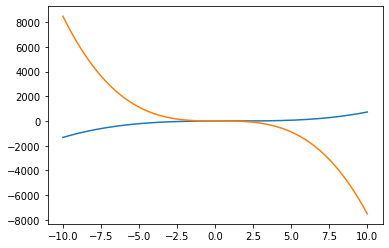

In [9]:
plt.plot(x, cubic.forward(x))